# NCAA March Madness (MoneyBall edition)
### This notebook will cover the complete process of building a classifier machine learning model to predict the win probability of each matchup in the 2019 NCAA March Madness Tournament.
### There are three major milestones:
1. Create training and test datasets
2. Create a machine learning model and train using the training set
3. Test the model using the test sets and create a submission file for Stage 1 of the Kaggle competition
4. Update datasets with 2019 data and create predictions for the 2019 NCAA March Madness Tournament (Stage 2 of the competition)

## Part 1: Creating the training/test set
### The dataset is generated from the following features:
* [The Four Factors](https://www.nbastuffer.com/analytics101/four-factors/)
* [Player Impact Estimate (PIE)](https://masseybasketball.blogspot.com/2013/07/player-impact-estimate.html)
* [Adjusted Offensive Efficiency](https://cbbstatshelp.com/efficiency/adjusted-efficiency/)
* [Adjusted Defensive Efficiency](https://cbbstatshelp.com/efficiency/adjusted-efficiency/)
* [Adjusted Efficiency Margin](https://cbbstatshelp.com/ratings/adjem/)
* [Defensive Rebounding Percentage](https://www.nbastuffer.com/analytics101/defensive-rebounding-percentage/)
* [Assist Ratio](https://www.nbastuffer.com/analytics101/assist-ratio/)
* Free Throw Percentage
* Score Differential
* [Rating Percentage Index (RPI)](https://en.wikipedia.org/wiki/Rating_Percentage_Index)
* Tournament Seed
* Win Percentage

#### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, log_loss,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost.sklearn import XGBClassifier

%matplotlib inline
pd.set_option('display.max_columns', 999)

#### Load Data Files

In [2]:
df_tourney = pd.read_csv('DataFiles/NCAATourneyCompactResults.csv')
df_season = pd.read_csv('DataFiles/RegularSeasonDetailedResults.csv')
df_teams = pd.read_csv('DataFiles/Teams.csv')
df_kenpom = pd.read_csv('DataFiles/KenPom.csv')
df_seeds = pd.read_csv('DataFiles/NCAATourneySeeds.csv')
# df_rankings = pd.read_csv('MasseyOrdinals/MasseyOrdinals.csv')
df_rankings = pd.read_csv('DataFiles/MasseyOrdinals_thru_2019_day_128.csv')
# df_sample_sub = pd.read_csv('SampleSubmissionStage1.csv')
df_sample_sub = pd.read_csv('SampleSubmissionStage2.csv')

# df_tourney = pd.read_csv('../input/mens-machine-learning-competition-2019/stage2datafiles/NCAATourneyCompactResults.csv')
# df_season = pd.read_csv('../input/mens-machine-learning-competition-2019/stage2datafiles/RegularSeasonDetailedResults.csv')
# df_teams = pd.read_csv('../input/mens-machine-learning-competition-2019/stage2datafiles/Teams.csv')
# df_kenpom = pd.read_csv('../input/scrape-data-from-kenpom-com/KenPom.csv')
# df_seeds = pd.read_csv('../input/mens-machine-learning-competition-2019/stage2datafiles/NCAATourneySeeds.csv')
# df_rankings = pd.read_csv('../input/mens-machine-learning-competition-2019/masseyordinals/MasseyOrdinals.csv')
# df_rankings = pd.read_csv('../input/mens-machine-learning-competition-2019/masseyordinals_thru_2019_day_128/MasseyOrdinals_thru_2019_day_128.csv')
# df_sample_sub = pd.read_csv('../input/mens-machine-learning-competition-2019/SampleSubmissionStage1.csv')
# df_sample_sub = pd.read_csv('../input/mens-machine-learning-competition-2019/SampleSubmissionStage2.csv')

#### Check for Team Names from KenPom that are not found in Kaggle's Teams

In [3]:
missing_teams = []
for i in df_kenpom['TeamName']:
    if not len(df_teams[df_teams['TeamName'] == i]):
        missing_teams.append(i)
if len(missing_teams):
    for i in missing_teams:
        print(i)
else:
    print('No missing teams.')

No missing teams.


In [4]:
df_kenpom['TeamID'] = df_kenpom['TeamName'].apply(
    lambda x: df_teams[df_teams['TeamName'] == x].values[0][0])

## Efficiency

### Possession
#### Formula $$ \text{poss} = 0.96(\text{FGA} + \text{TO} + 0.44\text{FTA} - \text{OR}) $$

### Shooting Efficiency
#### Formula $$ \text{shoot_eff} = \frac{\text{Score}}{\text{FGA} + 0.475\text{FTA}} $$

### Scoring Opportunity
#### Formula $$ \text{score_op} = \frac{\text{FGA} + 0.475\text{FTA}}{\text{poss}} $$

In [5]:
# Possession
df_season['WPoss'] = df_season.apply(
    lambda row: 0.96 * (row.WFGA + row.WTO + 0.44 * row.WFTA - row.WOR), axis=1
)
df_season['LPoss'] = df_season.apply(
    lambda row: 0.96 * (row.LFGA + row.LTO + 0.44 * row.LFTA - row.LOR), axis=1
)

# Shooting Efficiency
df_season['WSEf'] = df_season.apply(
    lambda row: row.WScore / (row.WFGA + 0.44 * row.WFTA), axis=1
)
df_season['LSEf'] = df_season.apply(
    lambda row: row.LScore / (row.LFGA + 0.44 * row.LFTA), axis=1)

# Scoring Opportunity
df_season['WSOp'] = df_season.apply(
    lambda row: (row.WFGA + 0.44 * row.WFTA) / row.WPoss, axis=1
)
df_season['LSOp'] = df_season.apply(
    lambda row: (row.LFGA + 0.44 * row.LFTA) / row.LPoss, axis=1
)

### True Shooting Percentage
#### Formula$$ \text{ts_pct} = \frac{\text{Score}}{2(\text{FGA} + 0.475\text{FTA})} \times 100$$

### Player Impact Estimate
#### Formula $$ \text{IE_numerator} = \text{Score} + \text{FGM} + \text{FTM} - \text{FGA} - \text{FTA} + \text{DR} + 0.5\text{OR} + \text{Ast} + \text{Stl} + 0.5\text{Blk} - \text{PF} - \text{TO} $$

$$ \text{IE} = \frac{\text{IE_numerator}}{\text{IE_numerator} + \text{opp_IE_numerator}} $$

In [6]:
# True Shooting Percentage
df_season['WTSP'] = df_season.apply(
    lambda row: row.WScore * 100 / (2 * (row.WFGA + 0.44 * row.WFTA)), axis=1
)
df_season['LTSP'] = df_season.apply(
    lambda row: row.LScore * 100 / (2 * (row.LFGA + 0.44 * row.LFTA)), axis=1
)

wPIE = df_season.apply(
    lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA +
    row.WDR + 0.5*row.WOR + row.WAst + row.WStl + 0.5*row.WBlk -
    row.WPF - row.WTO, axis=1
)
lPIE = df_season.apply(
    lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA +
    row.LDR + 0.5*row.LOR + row.LAst + row.LStl + 0.5*row.LBlk -
    row.LPF - row.LTO, axis=1
)

df_season['WPIE'] = wPIE / (wPIE + lPIE)
df_season['LPIE'] = lPIE / (wPIE + lPIE)

### Calculate Four Factors
#### Effective Field Goal Percentage $$  \text{efg_pct} = \frac{\text{FGM2} + 1.5\text{FGM3}}{\text{FGA}} $$
#### Turnover Rate $$ \text{to_poss} = \frac{\text{TO}}{\text{FGA} + 0.44\text{FTA} + \text{TO}} $$
#### Offensive Rebounding Percentage $$ \text{orb_pct} =  \frac{\text{OR}}{\text{OR} + \text{opp_DR}} $$
#### Free Throw Rate $$ \text{ft_rate} = \frac{\text{FTM}}{\text{FGA}} $$

In [7]:
# Effective Field Goal Percentage = (Field Goals Made + 0.5*3P Field Goals Made) / Field Goal Attempts
df_season['WeFGP'] = df_season.apply(lambda row: (row.WFGM + 0.5*row.WFGM3) / row.WFGA, axis=1)
df_season['LeFGP'] = df_season.apply(lambda row: (row.LFGM + 0.5*row.LFGM3) / row.LFGA, axis=1)

# Turnover Rate= Turnovers/(Field Goal Attempts + 0.44*Free Throw Attempts + Turnovers)
df_season['WToR'] = df_season.apply(lambda row: row.WTO / (row.WFGA + 0.44*row.WFTA + row.WTO), axis=1)
df_season['LToR'] = df_season.apply(lambda row: row.LTO / (row.LFGA + 0.44*row.LFTA + row.LTO), axis=1)

# Offensive Rebounding Percentage = Offensive Rebounds / (Offensive Rebounds + Opponent’s Defensive Rebounds)
df_season['WORP'] = df_season.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df_season['LORP'] = df_season.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)

# Free Throw Rate= Free Throws Made / Field Goals Attempted or Free Throws Attempted/Field Goals Attempted
df_season['WFTR'] = df_season.apply(lambda row: row.WFTA / row.WFGA, axis=1)
df_season['LFTR'] = df_season.apply(lambda row: row.LFTA / row.LFGA, axis=1)

# 4 Factors is weighted as follows
# 1. Shooting (40%)
# 2. Turnovers (25%)
# 3. Rebounding (20%)
# 4. Free Throws (15%)

# df_season['W4Factor'] = df_season.apply(lambda row: 0.4*row.WeFGP + 0.25*row.WToR + 0.2*row.WORP + 0.15*row.WFTR, axis=1)
# df_season['L4Factor'] = df_season.apply(lambda row: 0.4*row.LeFGP + 0.25*row.LToR + 0.2*row.LORP + 0.15*row.LFTR, axis=1)

### More on Efficiency
Instead of the standard offensive and defensive efficiency, I'm in favor of the adjusted efficiency numbers provided by [Ken Pomeroy](https://kenpom.com/). Unfortunately, I don't know how he calculates it. I have the numbers extracted from the website in the df_kenpom dataframe. I just need to add those numbers to the df_season dataframe

In [8]:
# Utility functions to isolate the efficiency stat for each team and year

def getAdjO(Year, TeamID):
    try:
        AdjO = df_kenpom[(df_kenpom['TeamID'] == TeamID) & (df_kenpom['Season'] == Year)].values[0][2]
    except IndexError:
        AdjO = df_kenpom[df_kenpom['TeamID'] == TeamID].mean().values[1].round(2)
    return AdjO

def getAdjD(Year, TeamID):
    try:
        AdjD = df_kenpom[(df_kenpom['TeamID'] == TeamID) & (df_kenpom['Season'] == Year)].values[0][3]
    except IndexError:
        AdjD = df_kenpom[df_kenpom['TeamID'] == TeamID].mean().values[2].round(2)
    return AdjD

def getAdjEM(Year, TeamID):
    try:
        AdjEM = df_kenpom[(df_kenpom['TeamID'] == TeamID) & (df_kenpom['Season'] == Year)].values[0][4]
    except IndexError:
        AdjEM = df_kenpom[df_kenpom['TeamID'] == TeamID].mean().values[3].round(2)
    return AdjEM

### Other stats
#### Defensive Rebound  Percentage $$ \text{drb_pct} =  \frac{\text{DR}}{\text{DR} + \text{opp_OR}} $$
#### Rebound  Percentage $$ \text{reb_pct} =  \frac{\text{orb_pct} + \text{drb_pct}}{2} $$
#### Offensive Rebound to Turnover Margin $$ \text{OR} - \text{TO} $$
#### Assist Ratio $$ \text{ast_rtio} = \frac{\text{Ast} \times 100}{\text{FGA} + 0.44\text{FTA} + \text{TO} + \text{Ast}} $$
#### Block Percentage $$ \text{blk_pct} = \frac{\text{Blk} \times 100}{\text{opp_FGA2}} $$
#### Steal Percentage $$ \text{stl_pct} = \frac{\text{Stl} \times 100}{\text{opp_poss}} $$

In [9]:
# Adjusted Offensive Efficiency
df_season['WAdjO'] = df_season.apply(lambda row: getAdjO(row['Season'], row['WTeamID']), axis=1)
df_season['LAdjO'] = df_season.apply(lambda row: getAdjO(row['Season'], row['LTeamID']), axis=1)

# Adjusted Defensive Efficiency
df_season['WAdjD'] = df_season.apply(lambda row: getAdjD(row['Season'], row['WTeamID']), axis=1)
df_season['LAdjD'] = df_season.apply(lambda row: getAdjD(row['Season'], row['LTeamID']), axis=1)

# Adjusted Efficiency Margin
df_season['WAdjEM'] = df_season.apply(lambda row: getAdjEM(row['Season'], row['WTeamID']), axis=1)
df_season['LAdjEM'] = df_season.apply(lambda row: getAdjEM(row['Season'], row['LTeamID']), axis=1)

# Defensive Rebounding Percentage
df_season['WDRP'] = df_season.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df_season['LDRP'] = df_season.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)

# Rebound Percentage
df_season['WRP'] = df_season.apply(lambda row: (row.WORP + row.WDRP) / 2, axis=1)
df_season['LRP'] = df_season.apply(lambda row: (row.LORP + row.LDRP) / 2, axis=1)

# Offensive Rebound to Turnover Margin
df_season['WORTM'] = df_season.apply(lambda row: row.WOR - row.WTO, axis=1)
df_season['LORTM'] = df_season.apply(lambda row: row.LOR - row.LTO, axis=1)

# Assist Ratio
df_season['WAR'] = df_season.apply(lambda row: row.WAst * 100 / (row.WFGA + row.WFTA*0.44 + row.WAst + row.WTO), axis=1)
df_season['LAR'] = df_season.apply(lambda row: row.LAst * 100 / (row.LFGA + row.LFTA*0.44 + row.LAst + row.LTO), axis=1)

# Block Percentage
df_season['WBKP'] = df_season.apply(lambda row: row.WBlk * 100 / row.LFGA, axis=1)
df_season['LBKP'] = df_season.apply(lambda row: row.LBlk * 100 / row.WFGA, axis=1)

# Steal Percentage
df_season['WSTP'] = df_season.apply(lambda row: row.WStl * 100 / row.LPoss, axis=1)
df_season['LSTP'] = df_season.apply(lambda row: row.LStl * 100 / row.WPoss, axis=1)

# Free Throw Percentage
# df_season['WFTP'] = df_season.apply(lambda row: 0.0 if row.WFTA == 0 else row.WFTM / row.WFTA, axis=1)
# df_season['LFTP'] = df_season.apply(lambda row: 0.0 if row.LFTA == 0 else row.LFTM / row.LFTA, axis=1)

# Score Differential = Points scored - points allowed
df_season['WPtsDf'] = df_season.apply(lambda row: row.WScore - row.LScore, axis=1)
df_season['LPtsDf'] = df_season.apply(lambda row: row.LScore - row.WScore, axis=1)

### Drop "normal" stats columns

In [10]:
df_season.drop(labels=['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1, inplace=True)
df_season.drop(labels=['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'], axis=1, inplace=True)

In [11]:
df_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WPoss,LPoss,WSEf,LSEf,WSOp,LSOp,WTSP,LTSP,WPIE,LPIE,WeFGP,LeFGP,WToR,LToR,WORP,LORP,WFTR,LFTR,WAdjO,LAdjO,WAdjD,LAdjD,WAdjEM,LAdjEM,WDRP,LDRP,WRP,LRP,WORTM,LORTM,WAR,LAR,WBKP,LBKP,WSTP,LSTP,WPtsDf,LPtsDf
0,2003,10,1104,68,1328,62,N,0,71.9232,67.8528,1.031553,0.989151,0.916533,0.923764,51.577670,49.457562,0.532847,0.467153,0.491379,0.433962,0.258659,0.223104,0.388889,0.294118,0.310345,0.415094,110.3,112.1,95.7,89.1,14.60,23.01,0.705882,0.611111,0.547386,0.452614,-9,-8,12.755102,9.021200,1.886792,3.448276,10.316450,12.513348,6,-6
1,2003,10,1272,70,1393,63,N,0,65.6256,65.0880,0.994883,0.831135,1.072143,1.164577,49.744173,41.556728,0.602339,0.397661,0.483871,0.402985,0.155950,0.136674,0.375000,0.416667,0.306452,0.298507,110.9,114.4,94.1,91.1,16.72,23.28,0.583333,0.625000,0.479167,0.520833,2,8,16.103060,7.383966,5.970149,9.677419,6.145526,12.190365,7,-7
2,2003,11,1266,73,1437,61,N,0,61.2096,61.5552,1.031656,0.733879,1.156028,1.350333,51.582815,36.693936,0.736434,0.263566,0.482759,0.321918,0.123824,0.126156,0.435897,0.543860,0.500000,0.315068,120.5,106.6,99.2,95.4,21.30,11.17,0.456140,0.564103,0.446019,0.553981,7,19,15.664160,8.643872,2.739726,8.620690,8.122791,3.267461,12,-12
3,2003,11,1296,56,1457,50,N,0,55.3344,55.2960,1.084431,0.899281,0.933235,1.005498,54.221534,44.964029,0.754717,0.245283,0.513158,0.428571,0.188561,0.254692,0.230769,0.472222,0.815789,0.306122,104.6,97.1,102.1,102.9,2.52,-5.81,0.527778,0.769231,0.379274,0.620726,-6,-2,14.737406,10.765550,4.081633,7.894737,25.318287,7.228776,6,-6
4,2003,11,1400,77,1208,71,N,0,61.1712,60.3648,1.154077,0.961018,1.090709,1.223892,57.703837,48.050893,0.570732,0.429268,0.540984,0.435484,0.173439,0.119218,0.531250,0.488372,0.213115,0.435484,119.3,120.9,95.8,99.9,23.49,20.93,0.511628,0.468750,0.521439,0.478561,3,11,12.942192,12.515645,6.451613,1.639344,6.626378,11.443294,6,-6


### Calculate aggregate games  into season totals for each team

In [12]:
df_season_totals = pd.DataFrame()

# Calculate wins and losses to get winning percentage
df_season_totals['Wins'] = df_season['WTeamID'].groupby([df_season['Season'], df_season['WTeamID']]).count()
df_season_totals['Losses'] = df_season['LTeamID'].groupby([df_season['Season'], df_season['LTeamID']]).count()
df_season_totals['WinPCT'] = df_season_totals['Wins'] / (df_season_totals['Wins'] + df_season_totals['Losses'])

# Calculate averages for games team won
df_season_totals['WSEf'] = df_season['WSEf'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WSOp'] = df_season['WSOp'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WTSP'] = df_season['WTSP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WPIE'] = df_season['WPIE'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WeFGP'] = df_season['WeFGP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WToR'] = df_season['WToR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WORP'] = df_season['WORP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WFTR'] = df_season['WFTR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['W4Factor'] = df_season['W4Factor'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WAdjO'] = df_season['WAdjO'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WAdjD'] = df_season['WAdjD'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WAdjEM'] = df_season['WAdjEM'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WDRP'] = df_season['WDRP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WRP'] = df_season['WRP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WORTM'] = df_season['WORTM'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WAR'] = df_season['WAR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WBKP'] = df_season['WBKP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WSTP'] = df_season['WSTP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WFTP'] = df_season['WFTP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WPtsDf'] = df_season['WPtsDf'].groupby([df_season['Season'], df_season['WTeamID']]).mean()

# Calculate averages for games team lost
df_season_totals['LSEf'] = df_season['LSEf'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LSOp'] = df_season['LSOp'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LTSP'] = df_season['LTSP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LPIE'] = df_season['LPIE'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LeFGP'] = df_season['LeFGP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LToR'] = df_season['LToR'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LORP'] = df_season['LORP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LFTR'] = df_season['LFTR'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
# df_season_totals['L4Factor'] = df_season['L4Factor'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LAdjO'] = df_season['LAdjO'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LAdjD'] = df_season['LAdjD'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LAdjEM'] = df_season['LAdjEM'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LDRP'] = df_season['LDRP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LRP'] = df_season['LRP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['LORTM'] = df_season['LORTM'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LAR'] = df_season['LAR'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LBKP'] = df_season['LBKP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['LSTP'] = df_season['LSTP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LFTP'] = df_season['LFTP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LPtsDf'] = df_season['LPtsDf'].groupby([df_season['Season'], df_season['LTeamID']]).mean()

# Calculate weighted average using winning percent to weigh the statistic
df_season_totals['SEf'] = df_season_totals['WSEf']*df_season_totals['WinPCT'] + df_season_totals['LSEf']*(1 - df_season_totals['WinPCT'])
df_season_totals['SOp'] = df_season_totals['WSOp']*df_season_totals['WinPCT'] + df_season_totals['LSOp']*(1 - df_season_totals['WinPCT'])
df_season_totals['TSP'] = df_season_totals['WTSP']*df_season_totals['WinPCT'] + df_season_totals['LTSP']*(1 - df_season_totals['WinPCT'])
df_season_totals['PIE'] = df_season_totals['WPIE']*df_season_totals['WinPCT'] + df_season_totals['LPIE']*(1 - df_season_totals['WinPCT'])
df_season_totals['eFGP'] = df_season_totals['WeFGP']*df_season_totals['WinPCT'] + df_season_totals['LeFGP']*(1 - df_season_totals['WinPCT'])
df_season_totals['ToR'] = df_season_totals['WToR']*df_season_totals['WinPCT'] + df_season_totals['LToR']*(1 - df_season_totals['WinPCT'])
df_season_totals['ORP'] = df_season_totals['WORP']*df_season_totals['WinPCT'] + df_season_totals['LORP']*(1 - df_season_totals['WinPCT'])
df_season_totals['FTR'] = df_season_totals['WFTR']*df_season_totals['WinPCT'] + df_season_totals['LFTR']*(1 - df_season_totals['WinPCT'])
# df_season_totals['4Factor'] = df_season_totals['W4Factor']*df_season_totals['WinPCT'] + df_season_totals['L4Factor']*(1 - df_season_totals['WinPCT'])
df_season_totals['AdjO'] = df_season_totals['WAdjO']*df_season_totals['WinPCT'] + df_season_totals['LAdjO']*(1 - df_season_totals['WinPCT'])
df_season_totals['AdjD'] = df_season_totals['WAdjD']*df_season_totals['WinPCT'] + df_season_totals['LAdjD']*(1 - df_season_totals['WinPCT'])
df_season_totals['AdjEM'] = df_season_totals['WAdjEM']*df_season_totals['WinPCT'] + df_season_totals['LAdjEM']*(1 - df_season_totals['WinPCT'])
df_season_totals['DRP'] = df_season_totals['WDRP']*df_season_totals['WinPCT'] + df_season_totals['LDRP']*(1 - df_season_totals['WinPCT'])
df_season_totals['RP'] = df_season_totals['WRP']*df_season_totals['WinPCT'] + df_season_totals['LRP']*(1 - df_season_totals['WinPCT'])
df_season_totals['ORTM'] = df_season_totals['WORTM']*df_season_totals['WinPCT'] + df_season_totals['LORTM']*(1 - df_season_totals['WinPCT'])
df_season_totals['AR'] = df_season_totals['WAR']*df_season_totals['WinPCT'] + df_season_totals['LAR']*(1 - df_season_totals['WinPCT'])
df_season_totals['BKP'] = df_season_totals['WBKP']*df_season_totals['WinPCT'] + df_season_totals['LBKP']*(1 - df_season_totals['WinPCT'])
df_season_totals['STP'] = df_season_totals['WSTP']*df_season_totals['WinPCT'] + df_season_totals['LSTP']*(1 - df_season_totals['WinPCT'])
# df_season_totals['FTP'] = df_season_totals['WFTP']*df_season_totals['WinPCT'] + df_season_totals['LFTP']*(1 - df_season_totals['WinPCT'])
df_season_totals['PtsDf'] = df_season_totals['WPtsDf']*df_season_totals['WinPCT'] + df_season_totals['LPtsDf']*(1 - df_season_totals['WinPCT'])

df_season_totals.reset_index(inplace=True)

In [13]:
df_season_totals.head()

,Season,WTeamID,Wins,Losses,WinPCT,WSEf,WSOp,WTSP,WPIE,WeFGP,WToR,WORP,WFTR,WAdjO,WAdjD,WAdjEM,WDRP,WRP,WORTM,WAR,WBKP,WSTP,WPtsDf,LSEf,LSOp,LTSP,LPIE,LeFGP,LToR,LORP,LFTR,LAdjO,LAdjD,LAdjEM,LDRP,LRP,LORTM,LAR,LBKP,LSTP,LPtsDf,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf
0,2003,1102,12,16.0,0.428571,1.405448,0.911299,70.272383,0.755263,0.692162,0.182036,0.172188,0.541714,105.2,104.0,1.27,0.636526,0.404357,-7.250000,21.835584,6.220524,13.512599,15.583333,1.067783,0.902782,53.389130,0.288600,0.503591,0.201436,0.165271,0.375427,105.2,104.0,1.27,0.625778,0.595643,-7.250000,14.784036,2.395925,10.751581,-11.250000,1.212496,0.906432,60.624810,0.488599,0.584407,0.193121,0.168235,0.446693,105.2,104.0,1.27,0.630384,0.513663,-7.250000,17.806128,4.035039,11.934874,0.250000
1,2003,1103,13,14.0,0.481481,1.276487,0.994668,63.824370,0.615446,0.592604,0.155195,0.318510,0.554488,110.0,110.9,-0.92,0.620109,0.469309,-3.153846,17.844557,3.175111,10.419924,9.384615,1.074250,1.001258,53.712520,0.411540,0.484527,0.164085,0.294003,0.382163,110.0,110.9,-0.92,0.633394,0.530691,-2.571429,14.132212,4.416857,9.506952,-7.500000,1.171624,0.998085,58.581188,0.509717,0.536564,0.159805,0.305803,0.465135,110.0,110.9,-0.92,0.626998,0.501137,-2.851852,15.919638,3.818979,9.946531,0.629630
2,2003,1104,17,11.0,0.607143,1.098290,1.048932,54.914508,0.657820,0.506056,0.160278,0.367049,0.392488,110.3,95.7,14.60,0.703299,0.535174,0.470588,14.717291,7.217131,11.068112,13.176471,0.958718,1.040284,47.935880,0.349042,0.429002,0.178087,0.377756,0.341227,110.3,95.7,14.60,0.661550,0.464826,0.000000,10.596303,4.450447,7.933275,-9.454545,1.043458,1.045534,52.172904,0.536514,0.475785,0.167275,0.371256,0.372350,110.3,95.7,14.60,0.686897,0.507537,0.285714,13.098331,6.130219,9.836569,4.285714
3,2003,1105,7,19.0,0.269231,1.083291,0.994652,54.164526,0.641277,0.488400,0.197495,0.383144,0.425332,90.0,108.2,-18.25,0.667596,0.525370,-3.428571,14.730833,3.513315,15.253171,13.000000,0.981189,0.964808,49.059444,0.331704,0.446777,0.211586,0.317489,0.335248,90.0,108.2,-18.25,0.631796,0.474630,-5.789474,13.496470,6.516636,9.742372,-11.473684,1.008678,0.972843,50.433889,0.415050,0.457983,0.207792,0.335166,0.359501,90.0,108.2,-18.25,0.641434,0.488291,-5.153846,13.828799,5.708049,11.226049,-4.884615
4,2003,1106,13,15.0,0.464286,1.088203,0.969794,54.410152,0.741382,0.517668,0.220207,0.378952,0.395797,90.9,100.9,-9.95,0.714061,0.546506,-4.923077,13.763497,6.896016,14.090484,10.384615,0.959227,0.971095,47.961365,0.342262,0.450522,0.208100,0.323938,0.231093,90.9,100.9,-9.95,0.649253,0.453494,-4.600000,11.689995,4.442584,13.330701,-9.266667,1.019109,0.970491,50.955444,0.527568,0.481697,0.213721,0.349480,0.307563,90.9,100.9,-9.95,0.679342,0.496678,-4.750000,12.652692,5.581677,13.683458,-0.142857


### Identify null values

In [14]:
df_season_totals[pd.isnull(df_season_totals['Losses'])]

,Season,WTeamID,Wins,Losses,WinPCT,WSEf,WSOp,WTSP,WPIE,WeFGP,WToR,WORP,WFTR,WAdjO,WAdjD,WAdjEM,WDRP,WRP,WORTM,WAR,WBKP,WSTP,WPtsDf,LSEf,LSOp,LTSP,LPIE,LeFGP,LToR,LORP,LFTR,LAdjO,LAdjD,LAdjEM,LDRP,LRP,LORTM,LAR,LBKP,LSTP,LPtsDf,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf
4064,2014,1455,33,NaN,NaN,1.151440,1.064761,57.571979,0.697612,0.523191,0.137994,0.353977,0.479304,117.8,92.4,25.36,0.74727,0.550624,1.424242,14.976410,9.560431,11.120121,15.060606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449376,NaN,NaN,4.795885,7.615586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4211,2015,1246,34,NaN,NaN,1.138312,1.082450,56.915615,0.809886,0.520134,0.137713,0.402745,0.451499,121.3,84.4,36.91,0.68447,0.543607,2.294118,15.896766,12.456295,10.752158,20.941176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456393,NaN,NaN,4.200459,7.638465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Replace null values with actual values

In [15]:
df_season_totals.loc[4064, 'Losses'] = 0
df_season_totals.loc[4064, 'WinPCT'] = 1
df_season_totals.loc[4064, 'SEf'] = df_season_totals.loc[4064, 'WSEf']
df_season_totals.loc[4064, 'SOp'] = df_season_totals.loc[4064, 'WSOp']
df_season_totals.loc[4064, 'TSP'] = df_season_totals.loc[4064, 'WTSP']
df_season_totals.loc[4064, 'PIE'] = df_season_totals.loc[4064, 'WPIE']
df_season_totals.loc[4064, 'eFGP'] = df_season_totals.loc[4064, 'WeFGP']
df_season_totals.loc[4064, 'ToR'] = df_season_totals.loc[4064, 'WToR']
df_season_totals.loc[4064, 'ORP'] = df_season_totals.loc[4064, 'WORP']
df_season_totals.loc[4064, 'FTR'] = df_season_totals.loc[4064, 'WFTR']
# df_season_totals.loc[4064, '4Factor'] = df_season_totals.loc[4064, 'W4Factor']
df_season_totals.loc[4064, 'AdjO'] = df_season_totals.loc[4064, 'WAdjO']
df_season_totals.loc[4064, 'AdjD'] = df_season_totals.loc[4064, 'WAdjD']
df_season_totals.loc[4064, 'AdjEM'] = df_season_totals.loc[4064, 'WAdjEM']
df_season_totals.loc[4064, 'DRP'] = df_season_totals.loc[4064, 'WDRP']
df_season_totals.loc[4064, 'RP'] = df_season_totals.loc[4064, 'WRP']
df_season_totals.loc[4064, 'ORTM'] = df_season_totals.loc[4064, 'WORTM']
df_season_totals.loc[4064, 'AR'] = df_season_totals.loc[4064, 'WAR']
df_season_totals.loc[4064, 'BKP'] = df_season_totals.loc[4064, 'WBKP']
df_season_totals.loc[4064, 'STP'] = df_season_totals.loc[4064, 'WSTP']
# df_season_totals.loc[4064, 'FTP'] = df_season_totals.loc[4064, 'WFTP']
df_season_totals.loc[4064, 'PtsDf'] = df_season_totals.loc[4064, 'WPtsDf']

df_season_totals.loc[4211, 'Losses'] = 0
df_season_totals.loc[4211, 'WinPCT'] = 1
df_season_totals.loc[4211, 'SEf'] = df_season_totals.loc[4211, 'WSEf']
df_season_totals.loc[4211, 'SOp'] = df_season_totals.loc[4211, 'WSOp']
df_season_totals.loc[4211, 'TSP'] = df_season_totals.loc[4211, 'WTSP']
df_season_totals.loc[4211, 'PIE'] = df_season_totals.loc[4211, 'WPIE']
df_season_totals.loc[4211, 'eFGP'] = df_season_totals.loc[4211, 'WeFGP']
df_season_totals.loc[4211, 'ToR'] = df_season_totals.loc[4211, 'WToR']
df_season_totals.loc[4211, 'ORP'] = df_season_totals.loc[4211, 'WORP']
df_season_totals.loc[4211, 'FTR'] = df_season_totals.loc[4211, 'WFTR']
# df_season_totals.loc[4211, '4Factor'] = df_season_totals.loc[4211, 'W4Factor']
df_season_totals.loc[4211, 'AdjO'] = df_season_totals.loc[4211, 'WAdjO']
df_season_totals.loc[4211, 'AdjD'] = df_season_totals.loc[4211, 'WAdjD']
df_season_totals.loc[4211, 'AdjEM'] = df_season_totals.loc[4211, 'WAdjEM']
df_season_totals.loc[4211, 'DRP'] = df_season_totals.loc[4211, 'WDRP']
df_season_totals.loc[4211, 'RP'] = df_season_totals.loc[4211, 'WRP']
df_season_totals.loc[4211, 'ORTM'] = df_season_totals.loc[4211, 'WORTM']
df_season_totals.loc[4211, 'AR'] = df_season_totals.loc[4211, 'WAR']
df_season_totals.loc[4211, 'BKP'] = df_season_totals.loc[4211, 'WBKP']
df_season_totals.loc[4211, 'STP'] = df_season_totals.loc[4211, 'WSTP']
# df_season_totals.loc[4211, 'FTP'] = df_season_totals.loc[4211, 'WFTP']
df_season_totals.loc[4211, 'PtsDf'] = df_season_totals.loc[4211, 'WPtsDf']

### Keep only summary statistics

In [16]:
df_season_totals.columns

Index(['Season', 'WTeamID', 'Wins', 'Losses', 'WinPCT', 'WSEf', 'WSOp', 'WTSP',
       'WPIE', 'WeFGP', 'WToR', 'WORP', 'WFTR', 'WAdjO', 'WAdjD', 'WAdjEM',
       'WDRP', 'WRP', 'WORTM', 'WAR', 'WBKP', 'WSTP', 'WPtsDf', 'LSEf', 'LSOp',
       'LTSP', 'LPIE', 'LeFGP', 'LToR', 'LORP', 'LFTR', 'LAdjO', 'LAdjD',
       'LAdjEM', 'LDRP', 'LRP', 'LORTM', 'LAR', 'LBKP', 'LSTP', 'LPtsDf',
       'SEf', 'SOp', 'TSP', 'PIE', 'eFGP', 'ToR', 'ORP', 'FTR', 'AdjO', 'AdjD',
       'AdjEM', 'DRP', 'RP', 'ORTM', 'AR', 'BKP', 'STP', 'PtsDf'],
      dtype='object')

In [17]:
df_season_totals.drop(labels=['Wins', 'Losses', 'WSEf', 'WSOp', 'WTSP', 'WPIE', 'WeFGP', 'WToR', 'WORP', 'WFTR', 'WAdjO',
                              'WAdjD', 'WAdjEM', 'WDRP', 'WRP', 'WORTM', 'WAR', 'WBKP', 'WSTP', 'WPtsDf', 'LSEf', 'LSOp',
                              'LTSP', 'LPIE', 'LeFGP', 'LToR', 'LORP', 'LFTR', 'LAdjO', 'LAdjD', 'LAdjEM', 'LDRP', 'LRP',
                              'LORTM', 'LAR', 'LBKP', 'LSTP', 'LPtsDf'],
                      axis=1, inplace=True)

In [18]:
df_season_totals.head()

,Season,WTeamID,WinPCT,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf
0,2003,1102,0.428571,1.212496,0.906432,60.624810,0.488599,0.584407,0.193121,0.168235,0.446693,105.2,104.0,1.27,0.630384,0.513663,-7.250000,17.806128,4.035039,11.934874,0.250000
1,2003,1103,0.481481,1.171624,0.998085,58.581188,0.509717,0.536564,0.159805,0.305803,0.465135,110.0,110.9,-0.92,0.626998,0.501137,-2.851852,15.919638,3.818979,9.946531,0.629630
2,2003,1104,0.607143,1.043458,1.045534,52.172904,0.536514,0.475785,0.167275,0.371256,0.372350,110.3,95.7,14.60,0.686897,0.507537,0.285714,13.098331,6.130219,9.836569,4.285714
3,2003,1105,0.269231,1.008678,0.972843,50.433889,0.415050,0.457983,0.207792,0.335166,0.359501,90.0,108.2,-18.25,0.641434,0.488291,-5.153846,13.828799,5.708049,11.226049,-4.884615
4,2003,1106,0.464286,1.019109,0.970491,50.955444,0.527568,0.481697,0.213721,0.349480,0.307563,90.9,100.9,-9.95,0.679342,0.496678,-4.750000,12.652692,5.581677,13.683458,-0.142857


### Reorganize column headers and rename WTeamID to TeamID

In [19]:
columns = df_season_totals.columns.tolist()
columns.pop(2)
columns.append('WinPCT')
df_season_totals = df_season_totals[columns]
df_season_totals.rename(columns={'WTeamID': 'TeamID'}, inplace=True)
df_season_totals.head()

,Season,TeamID,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf,WinPCT
0,2003,1102,1.212496,0.906432,60.624810,0.488599,0.584407,0.193121,0.168235,0.446693,105.2,104.0,1.27,0.630384,0.513663,-7.250000,17.806128,4.035039,11.934874,0.250000,0.428571
1,2003,1103,1.171624,0.998085,58.581188,0.509717,0.536564,0.159805,0.305803,0.465135,110.0,110.9,-0.92,0.626998,0.501137,-2.851852,15.919638,3.818979,9.946531,0.629630,0.481481
2,2003,1104,1.043458,1.045534,52.172904,0.536514,0.475785,0.167275,0.371256,0.372350,110.3,95.7,14.60,0.686897,0.507537,0.285714,13.098331,6.130219,9.836569,4.285714,0.607143
3,2003,1105,1.008678,0.972843,50.433889,0.415050,0.457983,0.207792,0.335166,0.359501,90.0,108.2,-18.25,0.641434,0.488291,-5.153846,13.828799,5.708049,11.226049,-4.884615,0.269231
4,2003,1106,1.019109,0.970491,50.955444,0.527568,0.481697,0.213721,0.349480,0.307563,90.9,100.9,-9.95,0.679342,0.496678,-4.750000,12.652692,5.581677,13.683458,-0.142857,0.464286


### Strength of Schedule
#### Use RPI Ranking
#### Rating Percentage Index (RPI) Formula=.25(Team’s Winning Percentage)+.50(Opponents’ Average Winning Percentage)+0.25*(Opponents’ Opponents’ Average Winning Percentage)
#### Use the final pre-tournament rankings each year (RankingDayNum of 133)

In [20]:
# # Stage 1
# df_rpi_final = df_rankings[(df_rankings['SystemName'] == 'RPI') & (df_rankings['RankingDayNum'] == 133)]
# df_rpi_final.tail()

In [21]:
# Stage 2
df_net_2019 = df_rankings[df_rankings['SystemName'] == 'NET']
# df_rpi_2019 = df_rpi[df_rpi['Season'] == 2019]  # Unnecessary to filter on Season since NET is new for 2019
df_net_2019_final = df_net_2019[df_net_2019['RankingDayNum'] == 128]
df_net_2019_final.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
3788347,2019,128,NET,1101,156
3788348,2019,128,NET,1102,244
3788349,2019,128,NET,1103,113
3788350,2019,128,NET,1104,58
3788351,2019,128,NET,1105,346


In [22]:
# Stage 2
df_rpi = df_rankings[df_rankings['SystemName'] == 'RPI']  # This is necessary to get RPI rankings for 2018 and prior
df_rpi_prev_final = df_rpi[df_rpi['RankingDayNum'] == 133]
df_rpi_prev_final.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
127586,2003,133,RPI,1102,158
127587,2003,133,RPI,1103,182
127588,2003,133,RPI,1104,38
127589,2003,133,RPI,1105,313
127590,2003,133,RPI,1106,248


In [23]:
# Stage 2
df_rnt_final = pd.concat([df_rpi_prev_final, df_net_2019_final])
df_rnt_final['Season'].value_counts()

2019    353
2016    351
2018    351
2015    351
2017    351
2014    349
2010    347
2013    347
2011    345
2012    344
2009    343
2008    341
2007    336
2006    334
2005    330
2003    327
2004    326
Name: Season, dtype: int64

In [24]:
df_rnt_final = df_rnt_final.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_rnt_final.head()

,Season,TeamID,OrdinalRank
127586,2003,1102,158
127587,2003,1103,182
127588,2003,1104,38
127589,2003,1105,313
127590,2003,1106,248


### Inspect Seeds DataFrame

In [25]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### Convert string version of seed to integer in new column and drop the old column

In [26]:
df_seeds['Seed_new'] = df_seeds['Seed'].apply(lambda x: int(x[1:3]))
df_seeds.head()

,Season,Seed,TeamID,Seed_new
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [27]:
df_seeds.drop(labels='Seed', axis=1, inplace=True)
df_seeds.rename(columns={'Seed_new': 'Seed'}, inplace=True)
df_seeds.tail()

,Season,TeamID,Seed
2281,2019,1332,12
2282,2019,1414,13
2283,2019,1330,14
2284,2019,1159,15
2285,2019,1205,16


### Merge datasets together

In [28]:
# Use tourney seeds from 2003 on
df_seeds_final = df_seeds[df_seeds['Season'] > 2002]
df_seeds_final.head()

,Season,TeamID,Seed
1154,2003,1328,1
1155,2003,1448,2
1156,2003,1393,3
1157,2003,1257,4
1158,2003,1280,5


In [29]:
df_tourney_temp = pd.merge(left=df_seeds_final, right=df_rnt_final, how='left', on=['Season', 'TeamID'])
df_tourney_final = pd.merge(left=df_tourney_temp, right=df_season_totals, how='left', on=['Season', 'TeamID'])
df_tourney_final.head()

,Season,TeamID,Seed,OrdinalRank,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf,WinPCT
0,2003,1328,1,3,1.097001,1.048366,54.850031,0.604965,0.512124,0.155078,0.347284,0.332030,112.1,89.1,23.01,0.709854,0.521804,0.333333,15.360582,6.657073,10.808039,11.000000,0.800000
1,2003,1448,2,7,1.138695,1.037061,56.934770,0.637398,0.511972,0.178941,0.429724,0.472499,114.5,94.6,19.87,0.687237,0.542711,-0.344828,14.767892,6.783296,9.970992,10.793103,0.827586
2,2003,1393,3,9,1.111825,1.049132,55.591271,0.604162,0.515151,0.160408,0.385242,0.393873,114.4,91.1,23.28,0.630790,0.507086,0.689655,14.605903,9.886525,11.999020,10.206897,0.827586
3,2003,1257,4,11,1.143283,1.040386,57.164148,0.633058,0.528861,0.156505,0.356053,0.418922,115.8,93.0,22.75,0.664037,0.511824,-0.166667,16.223909,7.169700,10.379246,13.366667,0.800000
4,2003,1280,5,24,1.102949,0.997074,55.147444,0.643001,0.521359,0.197467,0.383446,0.323860,107.4,85.8,21.53,0.695785,0.522359,-2.966667,15.403314,6.608609,13.542439,10.000000,0.700000


In [30]:
len(df_tourney_final)

1132

### Create heatmap to show correlation between the various features and winning percentage

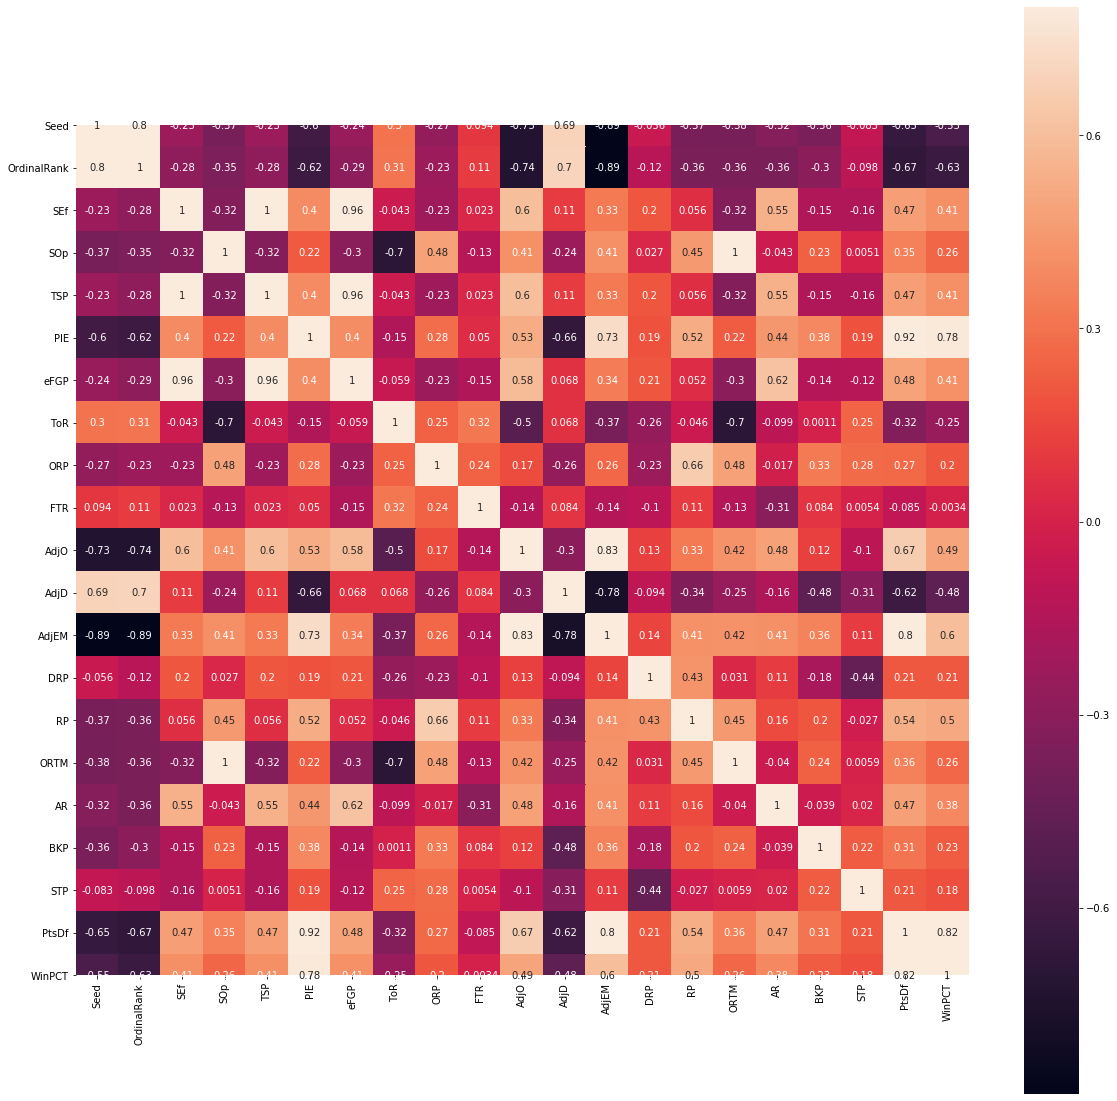

In [31]:
corrmatrix = df_tourney_final.iloc[:, 2:].corr()

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmatrix, vmax=0.8, annot=True, cbar=True, square=True)

### Create dataframe of features for winners in tournament since 2003

In [32]:
df_tourney.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tourney = df_tourney[df_tourney['Season'] > 2002]
df_tourney.reset_index(drop=True, inplace=True)
df_tourney.head()

,Season,WTeamID,LTeamID
0,2003,1421,1411
1,2003,1112,1436
2,2003,1113,1272
3,2003,1141,1166
4,2003,1143,1301


In [33]:
df_win_teams = pd.merge(
    left=df_tourney, right=df_tourney_final, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df_win_teams.drop(labels='TeamID', inplace=True, axis=1)
df_win_teams.head()

,Season,WTeamID,LTeamID,Seed,OrdinalRank,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf,WinPCT
0,2003,1421,1411,16,186,1.083649,0.984516,54.182467,0.440672,0.489800,0.196965,0.347184,0.377214,101.2,113.5,-12.35,0.625619,0.498362,-3.931034,13.598494,6.246397,11.673862,-7.241379,0.448276
1,2003,1112,1436,1,2,1.114667,1.049528,55.733373,0.654693,0.517632,0.160953,0.394027,0.387965,115.6,88.8,26.80,0.680560,0.532799,0.392857,16.071897,6.195106,11.034034,14.964286,0.892857
2,2003,1113,1272,10,32,1.114709,1.038513,55.735448,0.585160,0.517334,0.170036,0.398080,0.468561,113.9,97.4,16.49,0.683950,0.515260,-0.310345,15.835780,8.073294,8.750604,6.793103,0.620690
3,2003,1141,1166,11,44,1.248074,0.929604,62.403685,0.569291,0.572835,0.223575,0.359177,0.481836,109.5,99.4,10.01,0.662368,0.508803,-7.655172,15.826749,6.458459,10.940959,6.103448,0.793103
4,2003,1143,1301,8,33,1.112912,1.001198,55.645587,0.556130,0.524098,0.173660,0.322310,0.348311,109.9,96.3,13.59,0.692086,0.508335,-2.931034,16.240148,4.558823,9.608282,4.724138,0.724138


### Same for losers

In [34]:
df_loss_teams = pd.merge(
    left=df_tourney, right=df_tourney_final, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df_loss_teams.drop(labels='TeamID', inplace=True, axis=1)
df_loss_teams.head()

,Season,WTeamID,LTeamID,Seed,OrdinalRank,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf,WinPCT
0,2003,1421,1411,16,217,1.079638,1.013556,53.981890,0.547692,0.503036,0.184551,0.360133,0.529491,98.3,108.7,-10.45,0.681723,0.503287,-2.066667,14.483076,3.316907,10.124350,1.966667,0.600000
1,2003,1112,1436,16,144,1.056765,1.025805,52.838260,0.561326,0.494732,0.180141,0.380016,0.356274,101.1,99.5,1.57,0.732898,0.525437,-1.103448,15.154550,5.342473,10.745218,4.655172,0.655172
2,2003,1113,1272,7,26,1.068992,1.048248,53.449587,0.597778,0.498337,0.163772,0.366803,0.396624,110.9,94.1,16.72,0.683904,0.520205,0.275862,16.407177,8.186473,11.283464,8.689655,0.793103
3,2003,1141,1166,6,23,1.193801,1.005959,59.690051,0.644084,0.567455,0.167750,0.339233,0.354147,112.4,94.9,17.54,0.681826,0.510518,-2.484848,17.170311,8.012987,12.603229,14.909091,0.878788
4,2003,1143,1301,9,53,1.164220,0.973632,58.210991,0.541945,0.534189,0.185834,0.308813,0.387496,111.2,98.1,13.18,0.681661,0.501708,-4.466667,15.869982,5.583418,12.364782,4.400000,0.600000


### Create dataframe of winners - losers with added results column, merged to tourney matchups on the right

In [35]:
df_win_diff = df_win_teams.iloc[:, 3:] - df_loss_teams.iloc[:, 3:]
df_win_diff['result'] = 1
df_win_diff = pd.merge(left=df_win_diff, right=df_tourney, left_index=True, right_index=True, how='inner')
df_win_diff.head()

,Seed,OrdinalRank,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf,WinPCT,result,Season,WTeamID,LTeamID
0,0,-31,0.004012,-0.029039,0.200577,-0.107021,-0.013235,0.012414,-0.012949,-0.152277,2.9,4.8,-1.90,-0.056104,-0.004925,-1.864368,-0.884582,2.929490,1.549512,-9.208046,-0.151724,1,2003,1421,1411
1,-15,-142,0.057902,0.023723,2.895113,0.093367,0.022900,-0.019188,0.014010,0.031691,14.5,-10.7,25.23,-0.052338,0.007362,1.496305,0.917347,0.852633,0.288815,10.309113,0.237685,1,2003,1112,1436
2,3,6,0.045717,-0.009735,2.285861,-0.012618,0.018997,0.006264,0.031277,0.071937,3.0,3.3,-0.23,0.000045,-0.004945,-0.586207,-0.571396,-0.113179,-2.532859,-1.896552,-0.172414,1,2003,1113,1272
3,5,21,0.054273,-0.076355,2.713634,-0.074793,0.005381,0.055825,0.019944,0.127689,-2.9,4.5,-7.53,-0.019458,-0.001714,-5.170324,-1.343562,-1.554528,-1.662270,-8.805643,-0.085684,1,2003,1141,1166
4,-1,-20,-0.051308,0.027566,-2.565404,0.014185,-0.010092,-0.012174,0.013497,-0.039185,-1.3,-1.8,0.41,0.010425,0.006627,1.535632,0.370166,-1.024595,-2.756500,0.324138,0.124138,1,2003,1143,1301


### Same for losers

In [36]:
df_loss_diff = df_loss_teams.iloc[:, 3:] - df_win_teams.iloc[:, 3:]
df_loss_diff['result'] = 0
df_loss_diff = pd.merge(left=df_loss_diff, right=df_tourney, left_index=True, right_index=True, how='inner')
df_loss_diff.head()

,Seed,OrdinalRank,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf,WinPCT,result,Season,WTeamID,LTeamID
0,0,31,-0.004012,0.029039,-0.200577,0.107021,0.013235,-0.012414,0.012949,0.152277,-2.9,-4.8,1.90,0.056104,0.004925,1.864368,0.884582,-2.929490,-1.549512,9.208046,0.151724,0,2003,1421,1411
1,15,142,-0.057902,-0.023723,-2.895113,-0.093367,-0.022900,0.019188,-0.014010,-0.031691,-14.5,10.7,-25.23,0.052338,-0.007362,-1.496305,-0.917347,-0.852633,-0.288815,-10.309113,-0.237685,0,2003,1112,1436
2,-3,-6,-0.045717,0.009735,-2.285861,0.012618,-0.018997,-0.006264,-0.031277,-0.071937,-3.0,-3.3,0.23,-0.000045,0.004945,0.586207,0.571396,0.113179,2.532859,1.896552,0.172414,0,2003,1113,1272
3,-5,-21,-0.054273,0.076355,-2.713634,0.074793,-0.005381,-0.055825,-0.019944,-0.127689,2.9,-4.5,7.53,0.019458,0.001714,5.170324,1.343562,1.554528,1.662270,8.805643,0.085684,0,2003,1141,1166
4,1,20,0.051308,-0.027566,2.565404,-0.014185,0.010092,0.012174,-0.013497,0.039185,1.3,1.8,-0.41,-0.010425,-0.006627,-1.535632,-0.370166,1.024595,2.756500,-0.324138,-0.124138,0,2003,1143,1301


### Create prediction set by concatenating winners and losers on top of each other, sorted by Season

In [37]:
prediction_dataset = pd.concat((df_win_diff, df_loss_diff), axis=0)
prediction_dataset.sort_values('Season', inplace=True)
prediction_dataset.head()

,Seed,OrdinalRank,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf,WinPCT,result,Season,WTeamID,LTeamID
0,0,-31,0.004012,-0.029039,0.200577,-0.107021,-0.013235,0.012414,-0.012949,-0.152277,2.9,4.8,-1.90,-0.056104,-0.004925,-1.864368,-0.884582,2.929490,1.549512,-9.208046,-0.151724,1,2003,1421,1411
35,8,32,0.109774,-0.107025,5.488707,-0.035590,0.051091,0.060748,-0.015925,0.009712,-5.5,8.1,-13.74,0.008389,-0.003169,-7.388506,2.023715,-2.803146,-1.247872,-5.463218,-0.006897,0,2003,1181,1141
36,8,26,-0.003925,0.005430,-0.196226,-0.069708,-0.008127,0.000354,0.015229,0.078885,-1.1,11.0,-12.13,-0.016659,-0.007008,0.289655,-0.072113,0.049720,-5.533779,-8.173563,-0.145977,0,2003,1242,1113
37,3,7,-0.107576,0.002764,-5.378812,-0.074801,-0.029445,-0.000180,-0.053522,-0.124033,-9.0,-5.0,-3.98,0.002187,-0.024147,0.335253,-2.295495,0.757386,-0.592486,-5.423963,-0.144009,0,2003,1266,1281
38,-1,4,0.039971,-0.031766,1.998566,0.073193,0.032472,0.016010,-0.001813,-0.035005,-3.3,-7.5,4.16,0.029407,0.009088,-2.046237,2.264795,-3.748039,-0.415359,5.130108,0.090323,0,2003,1323,1228


In [38]:
prediction_dataset['Seed'] = prediction_dataset['Seed'].astype('float64')
prediction_dataset['OrdinalRank'] = prediction_dataset['OrdinalRank'].astype('float64')

# prediction_dataset['result'] = prediction_dataset['result'].astype('float64')
# prediction_dataset['Season'] = prediction_dataset['Season'].astype('float64')
# prediction_dataset['WTeamID'] = prediction_dataset['WTeamID'].astype('float64')
# prediction_dataset['LTeamID'] = prediction_dataset['LTeamID'].astype('float64')

## Part 2: Create and train the machine learning model
### Workflow:
* Create training set of data from 2014 and prior
* 2015-2018 data will be a true test set
* Split training set into a separate training and test set
* Initiate classifiers, create parameter and pipeline objects
* Use best performing classifer and fit with full training set
* Create data to input into the model
* Create predictions

### Split the dataframe into separate components

In [39]:
# # Stage 1
# labels = prediction_dataset['result']
# features = prediction_dataset.loc[:, :'WinPCT']
# IDs = prediction_dataset.loc[:, 'Season':]

# features.head()

In [40]:
# labels.head()

In [41]:
# IDs.head()

### Split components into 2003-2014 and 2015-2018 sets
#### Skip for stage 2

In [42]:
# # Identify numerical key at bottom row of 2003-2014 set (used to divide the observations into training and testing data)
# div_key = len(prediction_dataset[prediction_dataset['Season'] < 2015])

# # Identify column index at the end of the feature set (used to separate Season and Team IDs from the features)
# f_idx = features.shape[1]

In [43]:
# # Create 2015-2018 test set

# test_labels = prediction_dataset['result'][prediction_dataset['Season'] > 2014]
# test_features = prediction_dataset.iloc[div_key:, :f_idx]
# test_IDs = prediction_dataset.iloc[div_key:, f_idx + 1:]

In [44]:
# test_features.head()

In [45]:
# test_IDs.head()

In [46]:
# # Create the 2003-2014 training set

# y = prediction_dataset['result'][prediction_dataset['Season'] < 2015]
# X = prediction_dataset.iloc[:div_key, :f_idx]
# train_IDs = prediction_dataset.iloc[:div_key, f_idx + 1:]

In [47]:
# Stage 2
y = prediction_dataset['result']
X = prediction_dataset.loc[:, :'WinPCT']
train_IDs = prediction_dataset.loc[:, 'Season':]

X.head()

,Seed,OrdinalRank,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf,WinPCT
0,0.0,-31.0,0.004012,-0.029039,0.200577,-0.107021,-0.013235,0.012414,-0.012949,-0.152277,2.9,4.8,-1.90,-0.056104,-0.004925,-1.864368,-0.884582,2.929490,1.549512,-9.208046,-0.151724
35,8.0,32.0,0.109774,-0.107025,5.488707,-0.035590,0.051091,0.060748,-0.015925,0.009712,-5.5,8.1,-13.74,0.008389,-0.003169,-7.388506,2.023715,-2.803146,-1.247872,-5.463218,-0.006897
36,8.0,26.0,-0.003925,0.005430,-0.196226,-0.069708,-0.008127,0.000354,0.015229,0.078885,-1.1,11.0,-12.13,-0.016659,-0.007008,0.289655,-0.072113,0.049720,-5.533779,-8.173563,-0.145977
37,3.0,7.0,-0.107576,0.002764,-5.378812,-0.074801,-0.029445,-0.000180,-0.053522,-0.124033,-9.0,-5.0,-3.98,0.002187,-0.024147,0.335253,-2.295495,0.757386,-0.592486,-5.423963,-0.144009
38,-1.0,4.0,0.039971,-0.031766,1.998566,0.073193,0.032472,0.016010,-0.001813,-0.035005,-3.3,-7.5,4.16,0.029407,0.009088,-2.046237,2.264795,-3.748039,-0.415359,5.130108,0.090323


In [48]:
# # Split the 2003-2014 set even further

# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [49]:
# Stage 2
# Split the data into training data and a test set

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

In [50]:
# Initiate classifiers

clf1 = LogisticRegression(random_state=32)
clf2 = SVC(probability=True, random_state=32)                            
clf3 = XGBClassifier(objective='binary:logistic', random_state=32)
clf4 = DecisionTreeClassifier(random_state=32) 
clf5 = RandomForestClassifier(random_state=32)
clf6 = GradientBoostingClassifier(random_state=32)
sclr = StandardScaler()

In [51]:
# Configure Parameter grids

param_grid1 = [{'clf1__C': list(np.logspace(start=-5, stop=3, num=9)),
                'clf1__solver': ['newton-cg', 'lbfgs', 'liblinear'],
                'clf1__max_iter': [10000],
                'clf1__multi_class': ['ovr'],}]

param_grid2 = [{'clf2__C': np.logspace(start=-3, stop=3, num=7),
                'clf2__gamma': np.logspace(start=-4, stop=-1, num=4)}]

param_grid3 = [{'clf3__learning_rate': [0.1, 0.3],
                'clf3__max_depth': [2, 4, 8, 12],
                'clf3__min_child_weight': [2, 4, 8],
                'clf3__colsample_bytree': [0.25, 0.5, 0.75]}]

param_grid4 = [{'clf4__max_depth': list(range(3, 6)),
                'clf4__criterion': ['gini', 'entropy'],
                'clf4__min_samples_leaf': np.linspace(0.1, 0.5, 5),
                'clf4__min_samples_split': np.linspace(0.1, 0.5, 5)}]

param_grid5 = [{'clf5__n_estimators': [16, 32, 64, 128],
                'clf5__max_depth': list(range(1, 5)),
                'clf5__criterion': ['gini', 'entropy'],
                'clf5__min_samples_leaf': [2, 4, 8, 16],
                'clf5__min_samples_split' : [2, 3]}]

param_grid6 = [{'clf6__learning_rate' : [0.01, 0.1],
                'clf6__loss' : ['deviance','exponential'],
                'clf6__max_depth': list(range(3, 4))}]

In [52]:
# Build the pipelines

pipe1 = Pipeline([('scaler', sclr), ('clf1', clf1)])

pipe2 = Pipeline([('scaler', sclr), ('clf2', clf2)])

pipe3 = Pipeline([('scaler', sclr), ('clf3', clf3)])

pipe4 = Pipeline([('scaler', sclr), ('clf4', clf4)])

pipe5 = Pipeline([('scaler', sclr), ('clf5', clf5)])

pipe6 = Pipeline([('scaler', sclr), ('clf6', clf6)])

In [53]:
# Create empty list and initialize counter to build model comparison dataframe
mods = []
counter = 0

# Set up GridSearchCV objects, one for each algorithm
gridcvs = {}

inner_cv = StratifiedKFold(n_splits=10, shuffle=False, random_state=2)
outer_cv = StratifiedKFold(n_splits=10, shuffle=False, random_state=2)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3, param_grid4,
                             param_grid5, param_grid6),
                            (pipe1, pipe2, pipe3, pipe4, pipe5, pipe6),
                            ('Logistic', 'SVM', 'XGBoost', 'DTree', 'Random Forest', 'Gradient Boosting')):   

# First loop runs GridSearch and does Cross validation to find the best parameters

    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       iid=False,
                       scoring='neg_log_loss',
                       cv=outer_cv,
                       verbose=0,
                       refit=True,
                       return_train_score=False)
    
    gcv.fit(X_train, y_train)
    
    gridcvs[name] = gcv
    
    print(name)
    print()
    print(gcv.best_estimator_)
    print()
    print(f'Best score on Grid Search Cross Validation is {gcv.best_score_:.2f}')
    print()
      

# Inner loop runs Cross Val Score on tuned parameter model to determine accuracy of fit        

    # for name, gs_est in sorted(gridcvs.items()):
    
    nested_score = 0
    nested_score = cross_val_score(gcv, 
                                  X=X_test, 
                                  y=y_test, 
                                  cv=inner_cv,
                                  scoring='neg_log_loss')
                                
    
    print('Name, Log Loss, Std Dev, based on Best Parameter Model using Cross Validation Scoring')
    print(f'{name} | {nested_score.mean():.2f} {nested_score.std() * 100:.2f}')
    print()
    
    
# Generate predictions and probabilities
    
    best_algo = gcv    

    best_algo.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_true=y_train, y_pred=best_algo.predict(X_train))
    test_acc = accuracy_score(y_true=y_test, y_pred=best_algo.predict(X_test))
    
    predictions = best_algo.predict(X_test)
    probability = best_algo.predict_proba(X_test)[:, 1]
    
    auroc = roc_auc_score(y_test, probability)
    f1 = f1_score(y_test, predictions)
 
    print(f'Training Accuracy: {100 * train_acc:.2f}')
    print(f'Test Accuracy: {100 * test_acc:.2f}')
    print()
    print(f'Area under the ROC curve: {auroc:.3f}')
    print()
    
# Prints classification report and confusion matrix
    
#     if name != 'SVM':
        
    print(classification_report(y_test, predictions))
    print()
    print(confusion_matrix(y_test, predictions))
    print()
        
#     else:
#         print()

# Create a dataframe containing a single row of evaluation metrics for each algorithm

    mod = pd.DataFrame({'model_name': name, 'Train Accuracy': round(train_acc, 3),
                          'Test Accuracy': round(test_acc, 3), 'f1_score': round(f1, 3),
                          'AUROC': round(auroc, 3), 'Log Loss': round(nested_score.mean(), 3)}, index=[counter])
    
    mods.append(mod)
    counter += 1

# Concatenate single row dataframes into multirow dataframe for all algorithms
model_comp_plus_sclr = pd.concat(mods, ignore_index=False)

model_comp_plus_sclr.to_pickle('model_comp_plus_sclr.pkl')

Logistic

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf1',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=32,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Best score on Grid Search Cross Validation is -0.46

Name, Log Loss, Std Dev, based on Best Parameter Model using Cross Validation Scoring
Logistic | -0.47 9.67

Training Accuracy: 78.58
Test Accuracy: 78.81

Area under the ROC curve: 0.870

              precision    recall  f1-score   support

           0       0.78      0.78

Training Accuracy: 87.77
Test Accuracy: 75.71

Area under the ROC curve: 0.831

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       202
           1       0.77      0.75      0.76       218

    accuracy                           0.76       420
   macro avg       0.76      0.76      0.76       420
weighted avg       0.76      0.76      0.76       420


[[154  48]
 [ 54 164]]



In [54]:
# Sort models by Test Accuracy, f1 score, area under the ROC, and Log Loss
compare_models = model_comp_plus_sclr.copy()
compare_models.set_index('model_name', inplace=True)
metrics = ['Test Accuracy', 'f1_score', 'AUROC', 'Log Loss']

for metric in metrics:
    print(compare_models.sort_values(by=metric, ascending=False))

                   Train Accuracy  Test Accuracy  f1_score  AUROC  Log Loss
model_name                                                                 
SVM                         0.782          0.798     0.804  0.867    -0.480
Logistic                    0.786          0.788     0.795  0.870    -0.467
XGBoost                     0.811          0.767     0.773  0.851    -0.519
DTree                       0.757          0.757     0.762  0.831    -0.549
Gradient Boosting           0.878          0.757     0.763  0.831    -0.537
Random Forest               0.768          0.738     0.749  0.832    -0.528
                   Train Accuracy  Test Accuracy  f1_score  AUROC  Log Loss
model_name                                                                 
SVM                         0.782          0.798     0.804  0.867    -0.480
Logistic                    0.786          0.788     0.795  0.870    -0.467
XGBoost                     0.811          0.767     0.773  0.851    -0.519
Gradient Boo

In [55]:
# Initialize standard scaler and transform data

sclr = StandardScaler(copy=True, with_mean=True, with_std=True)

X = sclr.fit_transform(X)

In [88]:
# Initialize classifier and fit data

# clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, 
#                          max_iter=10000, multi_class='ovr', n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
#                          tol=0.0001, verbose=0, warm_start=False)

# clf = SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
#           kernel='rbf', max_iter=-1, probability=True, random_state=32, shrinking=True, tol=0.001, verbose=False)

# clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75, gamma=0,
#                     learning_rate=0.1, max_delta_step=0, max_depth=2, min_child_weight=8, missing=None,
#                     n_estimators=100, n_jobs=1, nthread=None, objective='binary:logistic', random_state=32,
#                     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=1, verbosity=1)

# clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3, max_features=None, max_leaf_nodes=None,
#                              min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=0.1, min_samples_split=0.1,
#                              min_weight_fraction_leaf=0.0, presort=False, random_state=32, splitter='best')

# clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=4, max_features='auto',
#                              max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=16,
#                              min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=None,
#                              oob_score=False, random_state=32, verbose=0, warm_start=False)

clf = GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=3,
                                 max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                 min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto',
                                 random_state=32, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
                                 warm_start=False)

# clf = LinearSVC(dual=False, C=10.0)

clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=32, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [57]:
# Create data to input into the model

n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

X_test = np.zeros(shape=(n_test_games, 1))
columns = df_tourney_final.columns.get_values()
model = []
data = []

for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    
    team1 = df_tourney_final[(df_tourney_final.TeamID == t1) & (df_tourney_final.Season == year)].values
    team2 = df_tourney_final[(df_tourney_final.TeamID == t2) & (df_tourney_final.Season == year)].values
    
    model = team1 - team2
    
    data.append(model)
    
Predictions = pd.DataFrame(np.array(data).reshape(n_test_games, df_tourney_final.shape[1]), columns = (columns))

Predictions.drop(labels=['Season', 'TeamID'], inplace=True, axis=1)

Predictions.head()

/home/mr_robot/miniconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  # Remove the CWD from sys.path while we load stuff.


,Seed,OrdinalRank,SEf,SOp,TSP,PIE,eFGP,ToR,ORP,FTR,AdjO,AdjD,AdjEM,DRP,RP,ORTM,AR,BKP,STP,PtsDf,WinPCT
0,4.0,89.0,0.023390,-0.016110,1.169520,0.024112,0.012205,-0.008024,-0.050080,-0.089934,-6.3,3.8,-10.20,-0.008955,-0.009056,-1.148707,2.368471,-0.232224,2.366562,2.077586,0.105603
1,10.0,139.0,-0.024189,-0.030364,-1.209460,-0.003338,-0.017923,0.002858,-0.044790,0.028202,-17.5,6.1,-23.65,0.050806,0.000799,-2.174442,1.324236,-3.732652,-2.068268,-3.466531,0.057809
2,6.0,120.0,0.042734,-0.039090,2.136688,0.029555,0.013981,-0.014694,-0.104458,0.013872,-11.9,3.2,-15.13,0.010894,-0.006733,-2.679957,1.464431,-3.301279,2.252408,2.358836,0.199353
3,4.0,111.0,-0.090397,0.000309,-4.519861,-0.034624,-0.058043,0.013790,0.019963,0.058582,-12.2,0.5,-12.74,-0.033916,-0.005638,0.113793,-2.813206,-0.750625,2.242233,-5.372414,-0.040230
4,0.0,-21.0,0.054901,0.017352,2.745065,0.057922,0.027274,-0.014762,0.005955,-0.021090,1.9,0.6,1.26,-0.007369,0.002504,0.928945,2.391081,-1.115556,3.570099,5.645768,0.217346


In [58]:
# Scale the prediction set
Predictions = sclr.fit_transform(Predictions)

In [89]:
# Generate the predictions

# preds = clf.predict(Predictions)
preds = clf.predict_proba(Predictions)[:,1]

df_sample_sub['Pred'] = preds
df_sample_sub.head()

,ID,Pred
0,2019_1101_1113,0.152360
1,2019_1101_1120,0.039958
2,2019_1101_1124,0.195914
3,2019_1101_1125,0.184029
4,2019_1101_1133,0.541585


In [90]:
# Generate submission file

# df_sample_sub.to_csv('Submissions/2019_predictions_lr_plus_sclr.csv', index=False)
# df_sample_sub.to_csv('Submissions/2019_predictions_svm_plus_sclr.csv', index=False)
# df_sample_sub.to_csv('Submissions/2019_predictions_xgb_plus_sclr.csv', index=False)
# df_sample_sub.to_csv('Submissions/2019_predictions_dtree_plus_sclr.csv', index=False)
# df_sample_sub.to_csv('Submissions/2019_predictions_rf_plus_sclr.csv', index=False)
df_sample_sub.to_csv('Submissions/2019_predictions_gb_plus_sclr.csv', index=False)
# df_sample_sub.to_csv('Predictions/2018_predictions_lsvc.csv', index=False)

In [91]:
# Use to fill out a bracket
def build_team_dict():
    team_ids = pd.read_csv('DataFiles/Teams.csv')
    team_id_map = {}
    for index, row in team_ids.iterrows():
        team_id_map[row['TeamID']] = row['TeamName']
    return team_id_map
team_id_map = build_team_dict()
readable = []
less_readable = []  # A version that's easy to look up.
submission_data = df_sample_sub.values.tolist()
for pred in submission_data:
    parts = pred[0].split('_')
    less_readable.append(
        [team_id_map[int(parts[1])], team_id_map[int(parts[2])], pred[1]])
    # Order them properly.
    if pred[1] > 0.5:
        winning = int(parts[1])
        losing = int(parts[2])
        proba = pred[1]
    else:
        winning = int(parts[2])
        losing = int(parts[1])
        proba = 1 - pred[1]
    readable.append(
        [
            '%s beats %s: %f' %
            (team_id_map[winning], team_id_map[losing], proba)
        ]
    )

In [92]:
# Use to fill out a bracket
Finalpredictions=pd.DataFrame(readable)
Finalpredictions.to_csv('Predictions/GB_plus_sclr_predictions.csv', index=False)